In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [25]:
df = pd.read_json('../train.json')

Каков размер (количество строк и столбцов) данных?

In [26]:
# Размер (строки, столбцы)
df.shape

(49352, 15)

Список столбцов. Какой столбец является целевым?

In [27]:
#столбцы
df.columns.tolist()

['bathrooms',
 'bedrooms',
 'building_id',
 'created',
 'description',
 'display_address',
 'features',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'photos',
 'price',
 'street_address',
 'interest_level']

Целевой это price

Провожу быстрый анализ данных, используя методы info(), describe(), corr(). Есть ли пустые столбцы?

In [28]:
print ('Base info:')
df.info()

print('Статистика числовых столбцов:')
print(df.describe())

print('Пустые значения:')
print(df.isnull().sum())

print('Матрица корреляций:')
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(df[numeric_columns].corr())

Base info:
<class 'pandas.core.frame.DataFrame'>
Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB
Статистика числовых столбцов:
         b

пустых столбцов НЕТ

Работаю только с тремя характеристиками: 'ванные комнаты', 'спальни', 'уровень интереса' и с целевым столбцом 'цена'. Создаю фрейм данных, содержащий только эти столбцы.

In [29]:
features_df = df[['bathrooms', 'bedrooms', 'interest_level', 'price']]
features_df.head()

,bathrooms,bedrooms,interest_level,price
4,1.0,1,medium,2400
6,1.0,2,low,3800
9,1.0,2,medium,3495
10,1.5,3,medium,3000
15,1.0,0,low,2795


Пытаюсь построить гистограмму, чтобы понять распределение цели

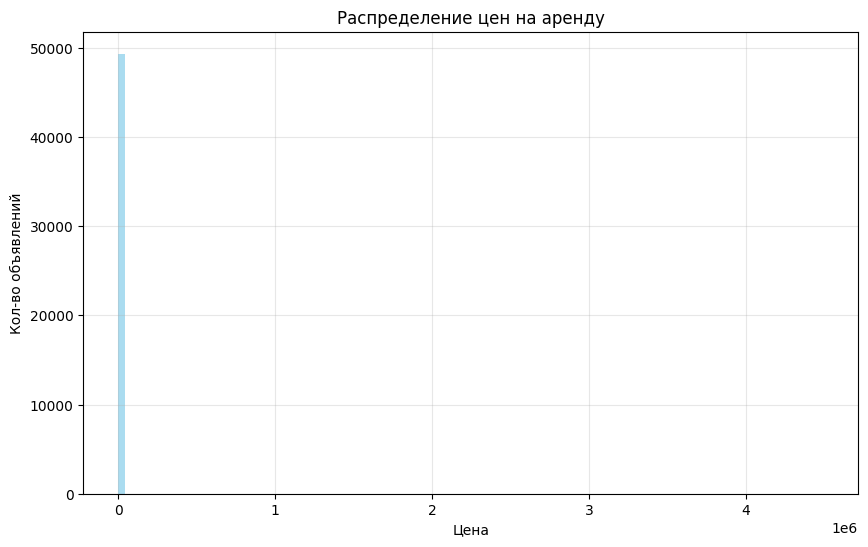

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(features_df['price'], bins=100, alpha=0.7, color='skyblue')
plt.title('Распределение цен на аренду')
plt.xlabel('Цена')
plt.ylabel('Кол-во объявлений')
plt.grid(True, alpha=0.3)
plt.show()

Ничего не понятно

Проблема: данные сконцентрированы в очень узком диапазоне (2000-5000) и сливаются в один столбик (ибо объявлений много). все слиплось

Следующий шаг - boxplot() 

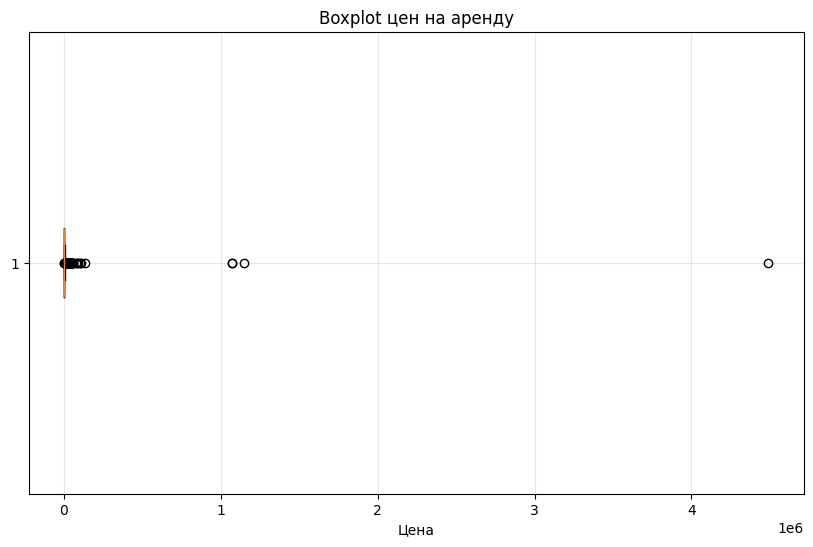

In [31]:
plt.figure(figsize=(10, 6))
plt.boxplot(features_df['price'], vert=False)

plt.title('Boxplot цен на аренду')
plt.xlabel('Цена')
plt.grid(True, alpha=0.3)
plt.show()

проблема та же, выбросов сказочно много

Нужно удалить строки, находящиеся за пределами 1 и 99 процентилей из целевого столбца.

In [32]:
p1 = features_df['price'].quantile(0.01)
p99 = features_df['price'].quantile(0.99)

features_df_clean = features_df[(features_df['price'] >= p1) & (features_df['price'] <=p99)].copy()

Другая гистограмма цены

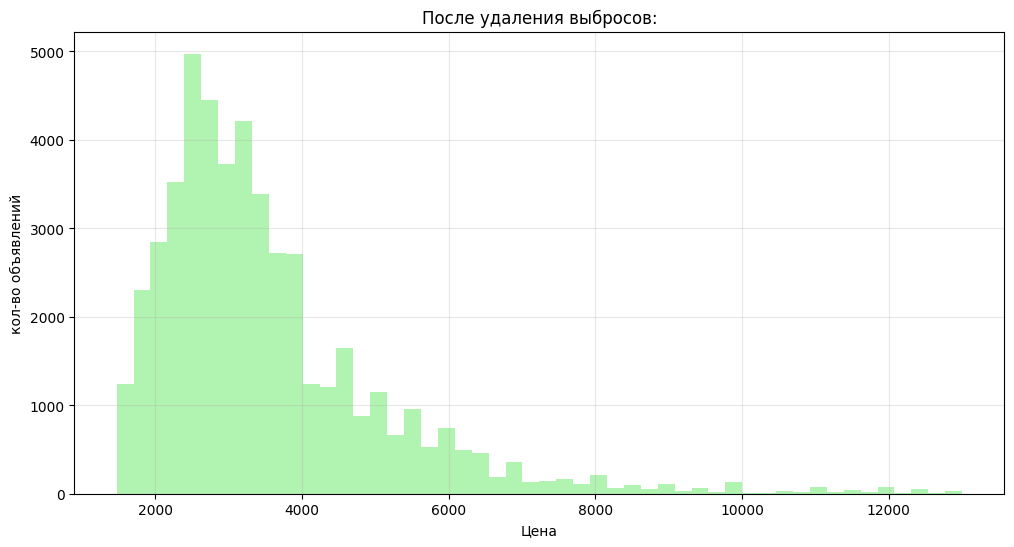

In [33]:
plt.figure(figsize=(12, 6))
plt.hist(features_df_clean['price'], bins=50, alpha=0.7, color='lightgreen')
plt.title('После удаления выбросов:')
plt.xlabel('Цена')
plt.ylabel('кол-во объявлений')
plt.grid(True, alpha=0.3)
plt.show()

Что изменилось?
Процентиль - значение, ниже которого находится определенный % данных.
1-й процентиль - значение ниже которого 1% данных.
99-й - ниже которого 99% данных.
50-й - медиана.

я убрала выбросы

Какой тип у столбца 'interest_level'?

In [34]:
print(features_df_clean['interest_level'].dtype)

object


Вывожу значения в этом столбце. Сколько записей содержит каждое значение?

In [35]:
interest_count = features_df_clean['interest_level'].value_counts()
print (interest_count)

interest_level
low       33697
medium    11116
high       3566
Name: count, dtype: int64


Нужно закодировать эти значения. Например, заменить каждое значение на 0, 1 или 2.

In [36]:
features_df_clean['interest_level_encoded'] = features_df_clean['interest_level'].map({
    'low': 0,
    'medium': 1,
    'high': 2
})

print(features_df_clean[['interest_level', 'interest_level_encoded']].head(10))

   interest_level  interest_level_encoded
4          medium                       1
6             low                       0
9          medium                       1
10         medium                       1
15            low                       0
16            low                       0
18            low                       0
19           high                       2
23            low                       0
32            low                       0


Гистограмма для признаков 'ванные комнаты', 'спальни'. Есть ли выбросы?

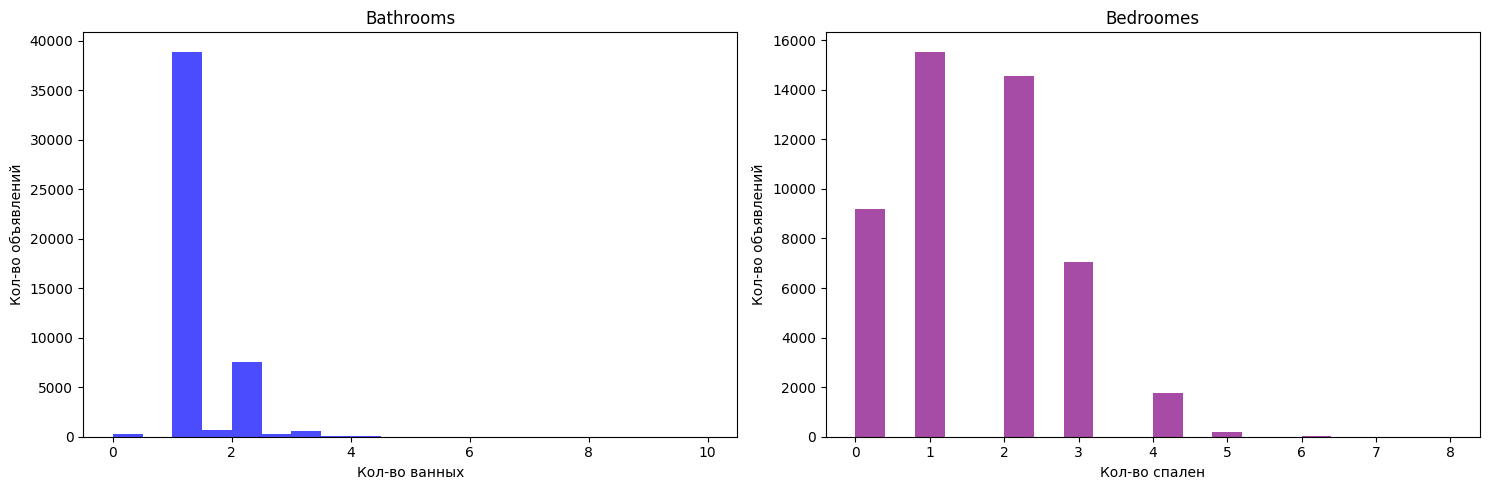

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].hist(features_df_clean['bathrooms'], bins=20, alpha=0.7, color='blue')
axes[0].set_title('Bathrooms')
axes[0].set_xlabel('Кол-во ванных')
axes[0].set_ylabel('Кол-во объявлений')

axes[1].hist(features_df_clean['bedrooms'], bins=20, alpha=0.7, color='purple')
axes[1].set_title('Bedroomes')
axes[1].set_xlabel('Кол-во спален')
axes[1].set_ylabel('Кол-во объявлений')

plt.tight_layout()
plt.show()

Корреляционная матрица, чтобы понять взаимосвязь между признаками и целевым показателем. И нужно сделать тепловую карту для корреляционной матрицы. Есть ли корреляция?

In [38]:
corr_matrix = features_df_clean[['bathrooms', 'bedrooms', 'interest_level_encoded', 'price']].corr()
corr_matrix

,bathrooms,bedrooms,interest_level_encoded,price
bathrooms,1.000000,0.517574,-0.063635,0.671943
bedrooms,0.517574,1.000000,0.050654,0.545948
interest_level_encoded,-0.063635,0.050654,1.000000,-0.200111
price,0.671943,0.545948,-0.200111,1.000000


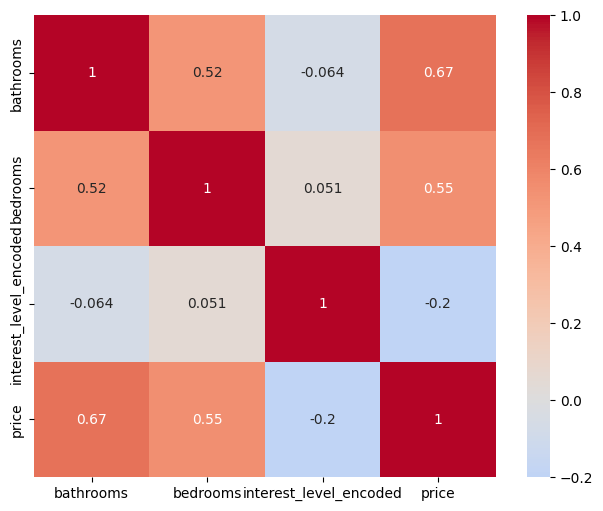

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.show()

самая большая корреляция между ценой и кол-вом bathrooms

Теперь точечная диаграмма, чтобы визуализировать взаимосвязь между признаками и целевым показателем. Создам 3 графика, где по оси X будет целевой показатель, а по оси Y — признак.

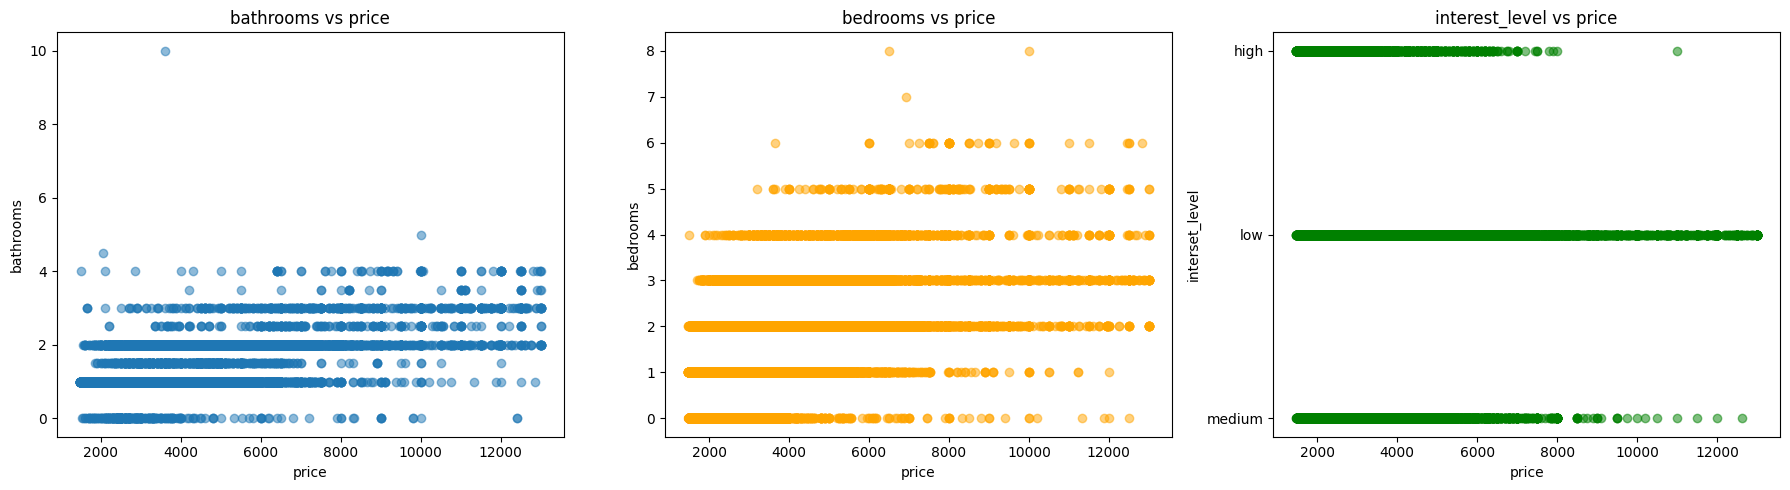

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(features_df_clean['price'], features_df_clean['bathrooms'], alpha=0.5)
axes[0].set_title('bathrooms vs price')
axes[0].set_xlabel('price')
axes[0].set_ylabel('bathrooms')

axes[1].scatter(features_df_clean['price'], features_df_clean['bedrooms'], alpha=0.5, color='orange')
axes[1].set_title('bedrooms vs price')
axes[1].set_xlabel('price')
axes[1].set_ylabel('bedrooms')

axes[2].scatter(features_df_clean['price'], features_df_clean['interest_level'], alpha=0.5, color='green')
axes[2].set_title('interest_level vs price')
axes[2].set_xlabel('price')
axes[2].set_ylabel('interset_level')

plt.tight_layout()
plt.show()

Следующий шаг очень обширный. Я создам новые признаки. Например, добавлю три новых признака, возведенных в квадрат: 'bathrooms_squared', 'bedrooms_squared', 'interest_level_squared'. Построю матрицу корреляции с новыми признаками. Связаны ли новые признаки с целевым показателем сильнее, чем базовые признаки?

In [41]:
features_df_clean['bathrooms_squared'] = features_df_clean['bathrooms'] ** 2
features_df_clean['bedrooms_squared'] = features_df_clean['bedrooms'] ** 2
features_df_clean['interest_level_squared'] = features_df_clean['interest_level_encoded'] ** 2

In [42]:
new_corr_matrix = features_df_clean[['bathrooms', 'bathrooms_squared', 'bedrooms', 'bedrooms_squared',
                                     'interest_level_encoded', 'interest_level_squared', 'price']].corr()
new_corr_matrix

,bathrooms,bathrooms_squared,bedrooms,bedrooms_squared,interest_level_encoded,interest_level_squared,price
bathrooms,1.000000,0.956023,0.517574,0.548760,-0.063635,-0.059410,0.671943
bathrooms_squared,0.956023,1.000000,0.478817,0.522227,-0.068558,-0.062240,0.648486
bedrooms,0.517574,0.478817,1.000000,0.928277,0.050654,0.039511,0.545948
bedrooms_squared,0.548760,0.522227,0.928277,1.000000,0.046340,0.035718,0.543406
interest_level_encoded,-0.063635,-0.068558,0.050654,0.046340,1.000000,0.944013,-0.200111
interest_level_squared,-0.059410,-0.062240,0.039511,0.035718,0.944013,1.000000,-0.182672
price,0.671943,0.648486,0.545948,0.543406,-0.200111,-0.182672,1.000000


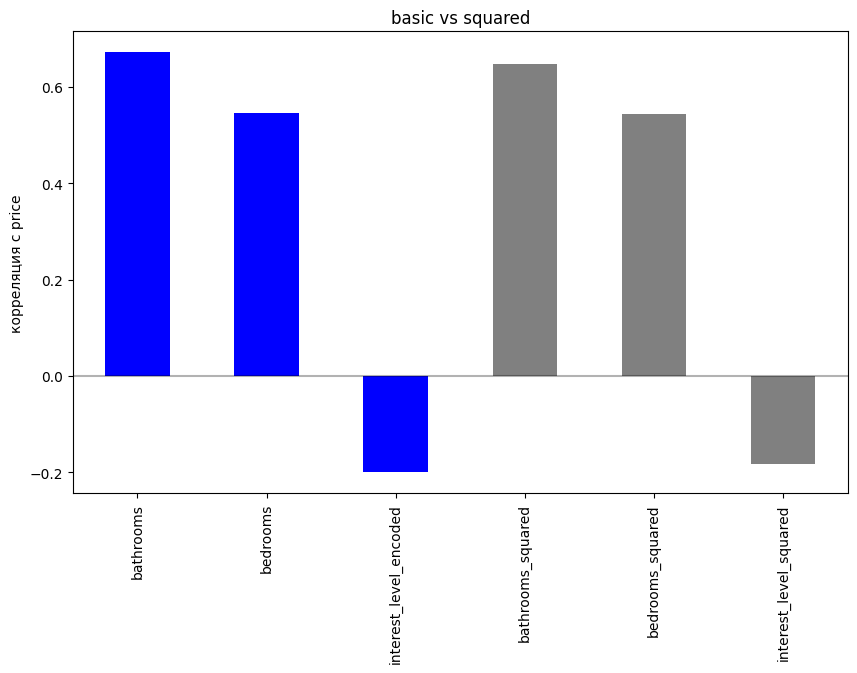

In [43]:
plt.figure(figsize=(10, 6))

basic_corr = corr_matrix.loc[['bathrooms', 'bedrooms', 'interest_level_encoded'], 'price']
new_corr = new_corr_matrix.loc[['bathrooms_squared', 'bedrooms_squared', 'interest_level_squared'], 'price']

all_corr = pd.concat([basic_corr, new_corr])
all_corr.plot(kind='bar', color=['blue', 'blue', 'blue', 'grey', 'grey', 'grey'])
plt.title('basic vs squared')
plt.ylabel('корреляция с price')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.show()

не особо помогло. мы искали нелинейные зависимости, но безуспешно

Чтобы использовать PolynomialFeatures, надо сначала разделить данные на обучающую и тестовую выборки. Это уже сделано. 
Инициализирую PolynomialFeatures() со степенью 10.

In [44]:
x_train = features_df_clean[['bathrooms', 'bedrooms']]
y_train = features_df_clean['price']

In [45]:
test_df = pd.read_json('../data/test.json')
test_df.shape

if 'price' in test_df.columns:
    x_test = test_df[['bathrooms', 'bedrooms']]
    y_test = test_df['price']
    print("В test.json есть цены для тестирования")
else:
    x_test = test_df[['bathrooms', 'bedrooms']]
    y_test = None
    print("Нет цен")

В test.json есть цены для тестирования


PolynomialFeatures() для подгонки и преобразования обучающих и тестовых данных.

In [46]:
poly = PolynomialFeatures(degree=10)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

print(f"Было признаков: {x_train.shape[1]}")
print(f"Стало признаков: {x_train_poly.shape[1]}")

Было признаков: 2
Стало признаков: 66


Создам два пустых фрейма данных Pandas со столбцами «модель», «обучение» и «тестирование». Назову первый фрейм result_MAE, а второй — result_RMSE. Потом заполню эти таблицы результатами работы моделей.

In [47]:
result_MAE = pd.DataFrame(columns=['model', 'train', 'test'])  # Mean Absolute Error (средняя абсолютная ошибка)
result_RMSE = pd.DataFrame(columns=['model', 'train', 'test']) # Root Mean Square Error (среднеквадратичная ошибка)

In [48]:
p1_test = test_df['price'].quantile(0.01)
p99_test = test_df['price'].quantile(0.99)

test_df_clean = test_df[(test_df['price'] >= p1_test) & (test_df['price'] <= p99_test)].copy()

print(f"Удалено выбросов: {len(test_df) - len(test_df_clean)}")
print(f"Осталось тестовых данных: {len(test_df_clean)}")

Удалено выбросов: 1443
Осталось тестовых данных: 73216


In [49]:
x_train = features_df_clean[['bathrooms', 'bedrooms']]
y_train = features_df_clean['price']

x_test_clean = test_df_clean[['bathrooms', 'bedrooms']]
y_test_clean = test_df_clean['price']

Инициализируем линейную регрессию из sklearn без параметров

In [50]:
linear_model = LinearRegression()

Подгоняю модель и делаю прогнозы на основе обучающих и тестовых данных. Сохраню их в виде новых столбцов в данных.

In [51]:
linear_model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [52]:
y_train_pred = linear_model.predict(x_train)
y_test_pred_clean = linear_model.predict(x_test_clean)

In [53]:
features_df_clean['linear_regression_pred'] = y_train_pred
test_df_clean['linear_regression_pred'] = y_test_pred_clean

MAE (средняя абсолютная ошибка) для обучающих и тестовых данных.

In [54]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test_clean, y_test_pred_clean)

print(f"MAE на обучающих данных: {train_mae:.2f}")
print(f"MAE на тестовых данных: {test_mae:.2f}")

MAE на обучающих данных: 784.56
MAE на тестовых данных: 790.48


Среднеквадратическая ошибка (RMSE) для обучающих и тестовых данных.

In [55]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_clean))

print(f"RMSE на обучающих данных: {train_rmse:.2f}")
print(f"RMSE на тестовых данных: {test_rmse:.2f}")

RMSE на обучающих данных: 1123.88
RMSE на тестовых данных: 1368.57


Вставляем показатели в таблицы result_MAE и result_RMSE с названием модели «линейная регрессия».

In [56]:
result_MAE.loc[0] = ['linear_regression', train_mae, test_mae]
result_RMSE.loc[0] = ['linear_regression', train_rmse, test_rmse]

Инициализирую дерево решений из sklearn с фиксированным значением random_state=21.

In [57]:
tree_model = DecisionTreeRegressor(random_state=21)

Подгоняю его под обучающие признаки и целевую функцию и делаю прогноз на основе обучающих и тестовых признаков. Сохраню его как новый столбец в данных.

In [58]:
tree_model.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,21
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [59]:
tree_model = DecisionTreeRegressor(random_state=21)
tree_model.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,21
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [60]:
y_train_pred_tree = tree_model.predict(x_train)
y_test_pred_tree_clean = tree_model.predict(x_test_clean)

In [61]:
features_df_clean['decision_tree_pred'] = y_train_pred_tree
test_df_clean['decision_tree_pred'] = y_test_pred_tree_clean

MAE

In [62]:
train_mae_tree = mean_absolute_error(y_train, y_train_pred_tree)
test_mae_tree = mean_absolute_error(y_test_clean, y_test_pred_tree_clean)

print(f"MAE на обучающих данных: {train_mae_tree:.2f}")
print(f"MAE на тестовых данных: {test_mae_tree:.2f}")

MAE на обучающих данных: 756.04
MAE на тестовых данных: 759.29


RMSE

In [63]:
train_rmse_tree = np.sqrt(mean_squared_error(y_train, y_train_pred_tree))
test_rmse_tree = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_tree_clean))

print(f"RMSE на обучающих данных: {train_rmse_tree:.2f}")
print(f"RMSE на тестовых данных: {test_rmse_tree:.2f}")

RMSE на обучающих данных: 1077.48
RMSE на тестовых данных: 1081.05


Вставляем показатели в таблицы result_MAE и result_RMSE с названием модели «дерево решений».

In [64]:
result_MAE.loc[1] = ['decision_tree', train_mae_tree, test_mae_tree]
result_RMSE.loc[1] = ['decision_tree', train_rmse_tree, test_rmse_tree]

Вычислим среднее значение и медиану для параметра «цена» в обучающих и тестовых данных и создадим столбец с этими значениями.

In [65]:
mean_price = y_train.mean()
median_price = y_train.median()

print(f"Средняя цена в обучающих данных: {mean_price:.2f}")
print(f"Медианная цена в обучающих данных: {median_price:.2f}")

Средняя цена в обучающих данных: 3538.64
Медианная цена в обучающих данных: 3150.00


In [66]:
y_train_pred_mean = [mean_price] * len(y_train)
y_test_pred_mean_clean = [mean_price] * len(y_test_clean)

y_train_pred_median = [median_price] * len(y_train)
y_test_pred_median_clean = [median_price] * len(y_test_clean)

print(f"naive_mean: всегда предсказываем {mean_price:.0f}")
print(f"naive_median: всегда предсказываем {median_price:.0f}")

naive_mean: всегда предсказываем 3539
naive_median: всегда предсказываем 3150


In [67]:
features_df_clean['naive_mean_pred'] = y_train_pred_mean
test_df_clean['naive_mean_pred'] = y_test_pred_mean_clean

features_df_clean['naive_median_pred'] = y_train_pred_median  
test_df_clean['naive_median_pred'] = y_test_pred_median_clean

MAE для тренировочных и тестовых целей между целью и рассчитанным средним значением и медианой.

In [68]:
# для mean

train_mae_mean = mean_absolute_error(y_train, y_train_pred_mean)
test_mae_mean = mean_absolute_error(y_test_clean, y_test_pred_mean_clean)
train_rmse_mean = np.sqrt(mean_squared_error(y_train, y_train_pred_mean))
test_rmse_mean = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_mean_clean))

print("naive_mean:")
print(f"MAE: train={train_mae_mean:.2f}, test={test_mae_mean:.2f}")
print(f"RMSE: train={train_rmse_mean:.2f}, test={test_rmse_mean:.2f}")

naive_mean:
MAE: train=1139.19, test=1137.34
RMSE: train=1597.65, test=1590.10


In [69]:
result_MAE.loc[2] = ['naive_mean', train_mae_mean, test_mae_mean]
result_RMSE.loc[2] = ['naive_mean', train_rmse_mean, test_rmse_mean]

RMSE

In [70]:
# Для naive_median
train_mae_median = mean_absolute_error(y_train, y_train_pred_median)
test_mae_median = mean_absolute_error(y_test_clean, y_test_pred_median_clean)
train_rmse_median = np.sqrt(mean_squared_error(y_train, y_train_pred_median))
test_rmse_median = np.sqrt(mean_squared_error(y_test_clean, y_test_pred_median_clean))

print("naive_median:")
print(f"MAE: train={train_mae_median:.2f}, test={test_mae_median:.2f}")
print(f"RMSE: train={train_rmse_median:.2f}, test={test_rmse_median:.2f}")

naive_median:
MAE: train=1086.21, test=1084.27
RMSE: train=1644.24, test=1635.38


In [71]:
result_MAE.loc[3] = ['naive_median', train_mae_median, test_mae_median]
result_RMSE.loc[3] = ['naive_median', train_rmse_median, test_rmse_median]

Итоговые таблицы result_MAE и result_RMSE.

In [72]:
print("result_MAE:")
result_MAE

result_MAE:


,model,train,test
0,linear_regression,784.563837,790.478922
1,decision_tree,756.044735,759.294165
2,naive_mean,1139.192515,1137.339895
3,naive_median,1086.210505,1084.274571


In [73]:
print("result_RMSE:")
result_RMSE

result_RMSE:


,model,train,test
0,linear_regression,1123.877748,1368.570772
1,decision_tree,1077.483596,1081.050194
2,naive_mean,1597.646655,1590.102981
3,naive_median,1644.236439,1635.375966


Какая модель лучше?

Decision Tree